# Power Spectra of different types of feathering #

In [1]:
# ipython notebook setup:
%matplotlib inline

In [2]:
import pylab as pl
pl.rcParams['image.interpolation'] = 'nearest'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (12,8)
pl.rcParams['image.cmap'] = 'viridis'
pl.rcParams['patch.edgecolor'] = 'none'
pl.rcParams['axes.prop_cycle'] = pl.cycler('color', ('#338ADD', '#9A44B6', '#A60628', '#467821', '#CF4457', '#188487', '#E24A33'))

In [3]:
from astropy import convolution
import numpy as np
from astropy import units as u
from uvcombine.uvcombine import feather_kernel, fftmerge, feather_simple
from turbustat.simulator.gen_field import make_extended
from turbustat.statistics import psds

In [4]:
# create an input image with specified parameters
# (this can later be modified - it will be good to examine the effects of
# different power laws, different types of input...)
# We're assuming a scale of 1"/pixel for this example
imsize = 512
im = make_extended(imsize=imsize+100, powerlaw=1.5, randomseed=0)
# crop down to the 'correct' imsize (we're doing this to avoid periodic boundaries)
im = im[50:-50, 50:-50]
# the real sky is positive.
im = im - im.min()

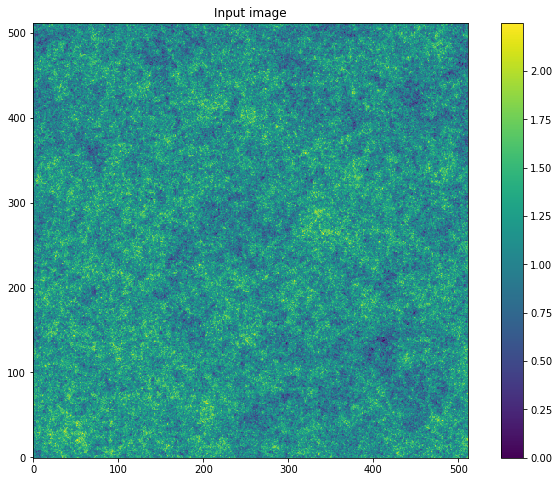

In [5]:
_=pl.imshow(im)
_=pl.title("Input image")
_=pl.colorbar()

In [6]:
ygrid, xgrid = np.indices(im.shape, dtype='float')
rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5

Create a UV sampling mask
-------------------------

This removes all large-angular scale (r<8) features *in UV space* and all small angular scales.

In fourier space, r=0 corresponds to the DC component
r=1 corresponds to the full map (one period over that map)
r=256 is the smallest angular scale, which is 2 pixels (nyquist sampling....?)

We're assuming a pixel scale of 1" / pixel
therefore 56" corresponds to 9m at 2mm (i.e., nearly the closest spacing possible for 7m)
We cut off the "interferometer" at 2.5" resolution

In [7]:
largest_scale = 56.
smallest_scale = 2.5
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

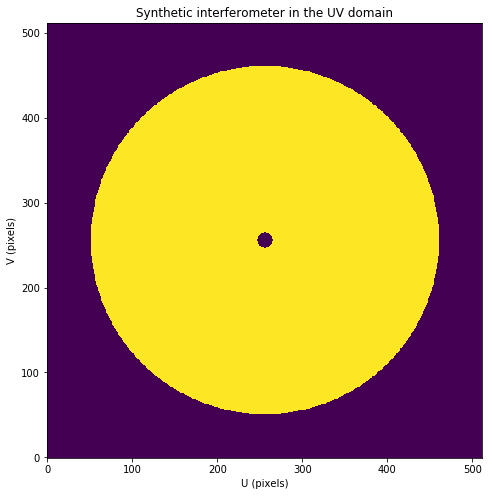

In [8]:
_=pl.imshow(ring)
_=pl.title("Synthetic interferometer in the UV domain")
_=pl.xlabel("U (pixels)")
_=pl.ylabel("V (pixels)")

### Create the interferometric map by removing both large and small angular scales in fourier space

In [9]:
imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered).real

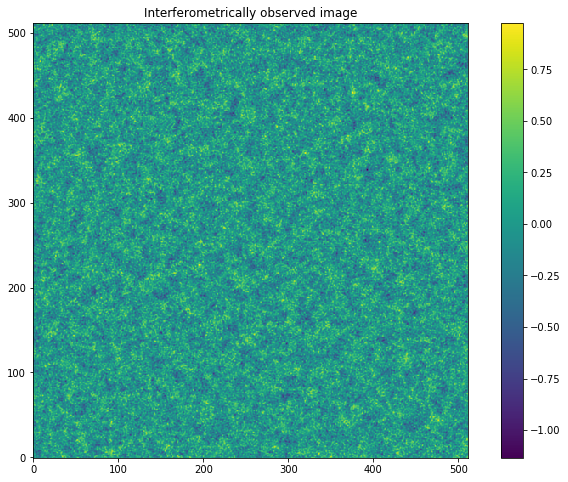

In [10]:
_=pl.imshow(im_interferometered)
_=pl.title("Interferometrically observed image")
_=pl.colorbar()

### Create the single-dish map by convolving the image with a FWHM=20" Gaussian kernel

(this interpretation is much easier than the sharp-edged stuff in fourier space because the kernel is created in real space)

In [11]:
lowresfwhm = 20*u.arcsec
pixscale = 1*u.arcsec
singledish_im = convolution.convolve_fft(im,
                                         convolution.Gaussian2DKernel((lowresfwhm/pixscale)/np.sqrt(8*np.log(2))),
                                         boundary='fill', fill_value=im.mean())

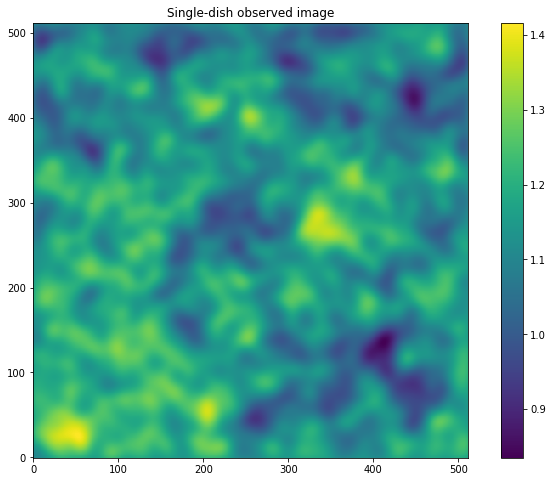

In [12]:
_=pl.imshow(singledish_im)
_=pl.title("Single-dish observed image")
_=pl.colorbar()

### Feather the data

This breaks the source code down; there's also a convenience function that achieves the same thing

In [13]:
# pixel scale can be interpreted as "arcseconds"
# then, fwhm=40 means a beam fwhm of 40"
pixscale = 1*u.arcsec
nax1,nax2 = im.shape
kfft, ikfft = feather_kernel(nax2, nax1, lowresfwhm, pixscale,)

8.493218002880191 20.0 arcsec 1.0 arcsec


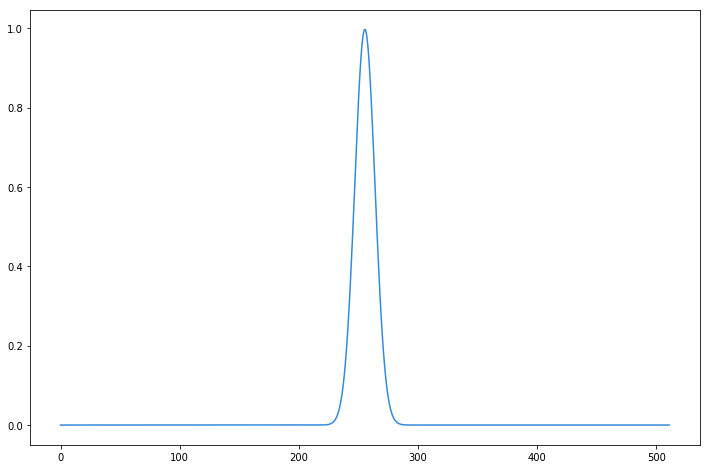

In [18]:
from astropy import units as u
### TEST ###
ygrid,xgrid = (np.indices([nax2,nax1]) -
               np.array([(nax2-1.)/2,(nax1-1.)/2.])[:,None,None])

# constant converting "resolution" in fwhm to sigma
fwhm = np.sqrt(8*np.log(2))

# sigma in pixels
sigma = ((lowresfwhm/fwhm/(pixscale)).decompose().value)
# not used, just noted that these are the theoretical values (...maybe...)
#sigma_fftspace = (1/(4*np.pi**2*sigma**2))**0.5
#sigma_fftspace = (2*np.pi*sigma)**-1
#log.debug('sigma = {0}, sigma_fftspace={1}'.format(sigma, sigma_fftspace))

# technically, the fftshift here does nothing since we're using the
# absolute value of the kernel below, so the phase is irrelevant
kernel = np.fft.fftshift(np.exp(-(xgrid**2+ygrid**2)/(2*sigma**2)))
# convert the kernel, which is just a gaussian in image space,
# to its corresponding kernel in fourier space
kfft = np.abs(np.fft.fft2(kernel)) # should be mostly real

if np.any(np.isnan(kfft)):
    raise ValueError("NaN value encountered in kernel")

# normalize the kernel
kfft/=kfft.max()
ikfft = 1-kfft

#pl.imshow(np.fft.fftshift(kernel))
pl.plot(np.fft.fftshift(kernel)[256,:])
print(sigma, lowresfwhm, pixscale)


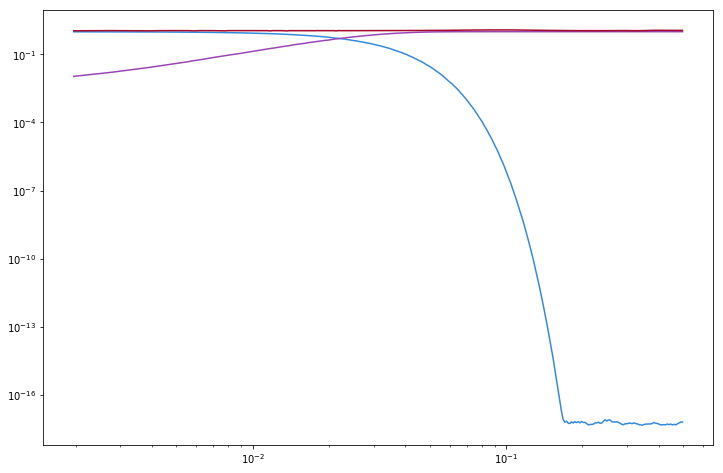

In [22]:
#pl.subplot(1,2,1).imshow(np.log10(np.fft.fftshift(kfft.real)))
#pl.subplot(1,2,2).imshow(np.log10(np.fft.fftshift(ikfft.real)))
x,y = psds.pspec(np.fft.fftshift(kfft.real))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y)

x,y = psds.pspec(np.fft.fftshift(ikfft.real))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y)

x,y = psds.pspec(np.fft.fftshift(singledish_im))
x = x[y==y]
y = y[y==y]
pl.loglog(x, y)

/Users/adam/repos/uvcombine/uvcombine/uvcombine.py:417: RuntimeWarning: divide by zero encountered in true_divide
  lo_conv = fft_lo / kfft
/Users/adam/repos/uvcombine/uvcombine/uvcombine.py:417: RuntimeWarning: invalid value encountered in true_divide
  lo_conv = fft_lo / kfft
/Users/adam/repos/uvcombine/uvcombine/uvcombine.py:417: RuntimeWarning: divide by zero encountered in true_divide
  lo_conv = fft_lo / kfft
/Users/adam/repos/uvcombine/uvcombine/uvcombine.py:417: RuntimeWarning: invalid value encountered in true_divide
  lo_conv = fft_lo / kfft
/Users/adam/miniconda3/lib/python3.7/site-packages/matplotlib/legend.py:652: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


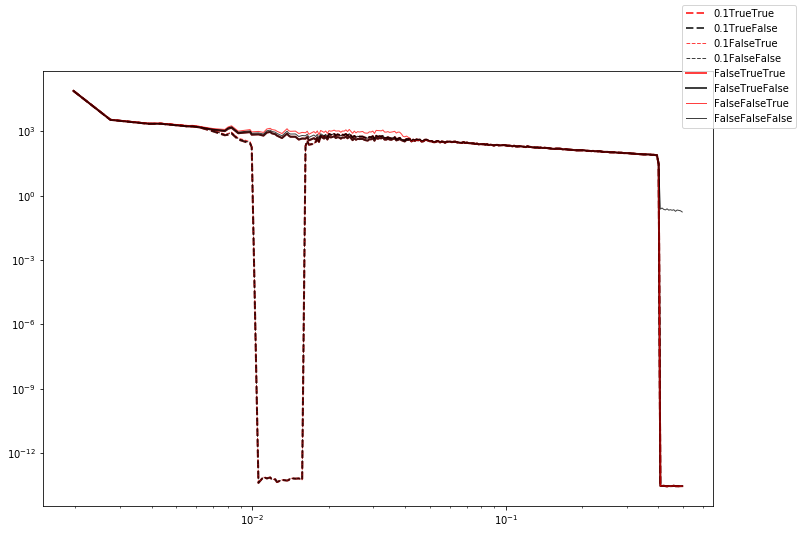

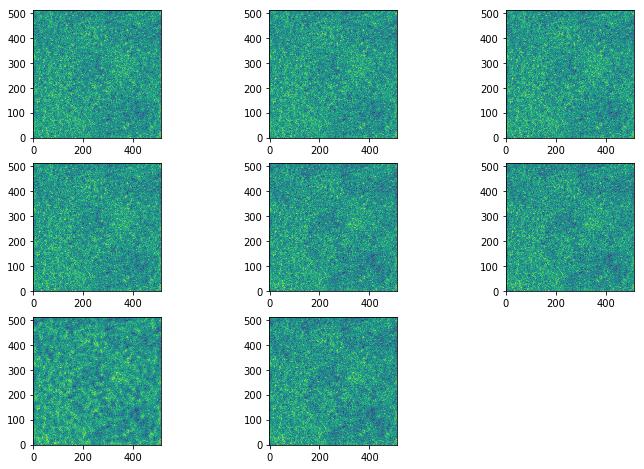

In [27]:
feathers = {}
fig1 = pl.figure(1)
ax1 = fig1.gca()

fig2 = pl.figure(2)
plotnum = 1
for replace_hires,ls in ((1e-1, '--'),(False,'-')):
    for highpassfilterSD,lw in ((True,2),(False,1)):
        for deconvSD,color in ((True,'r'), (False, 'k')):
            im_hi = im_interferometered
            im_low = singledish_im
            lowresscalefactor=1
            highresscalefactor=1
            fftsum, combo = fftmerge(kfft*1,
                                     ikfft*1,
                                     im_hi*highresscalefactor,
                                     im_low*lowresscalefactor,
                                     replace_hires=replace_hires,
                                     highpassfilterSD=highpassfilterSD,
                                     deconvSD=deconvSD,                                     
                                    )
            combo = combo.real
            feathers[replace_hires, highpassfilterSD, deconvSD] = combo
            
            
            pfreq, ppow = psds.pspec(np.fft.fftshift(np.abs(fftsum)))
            name = (f"{replace_hires}{highpassfilterSD}{deconvSD}")
            pfreq = pfreq[np.isfinite(ppow)]
            ppow = ppow[np.isfinite(ppow)]
            ax1.loglog(pfreq, ppow, label=name, linestyle=ls, linewidth=lw, color=color, alpha=0.75)
            ax2 = fig2.add_subplot(3, 3, plotnum)
            ax2.imshow(combo, interpolation='none', origin='lower')
            plotnum += 1
fig1.legend(loc='best')            

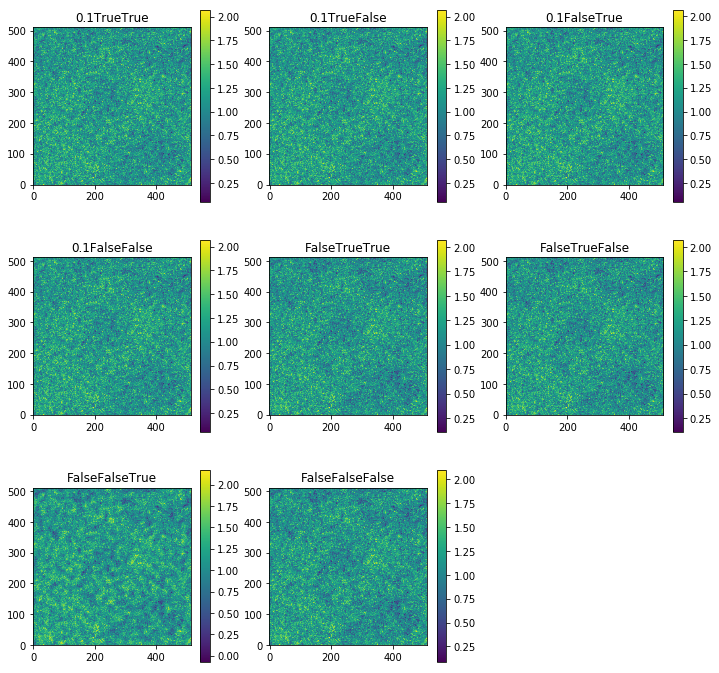

In [29]:
# Feathered dataset
pl.figure(1, figsize=(12,12)).clf()
ii = 1
for replace_hires in (1e-1,False):
    for highpassfilterSD in (True,False):
        for deconvSD in (True,False):
            _=pl.subplot(3,3,ii)
            _=pl.imshow(feathers[replace_hires, highpassfilterSD, deconvSD], cmap='viridis')
            _=pl.colorbar()
            _=pl.title(f"{replace_hires}{highpassfilterSD}{deconvSD}")
            ii+=1


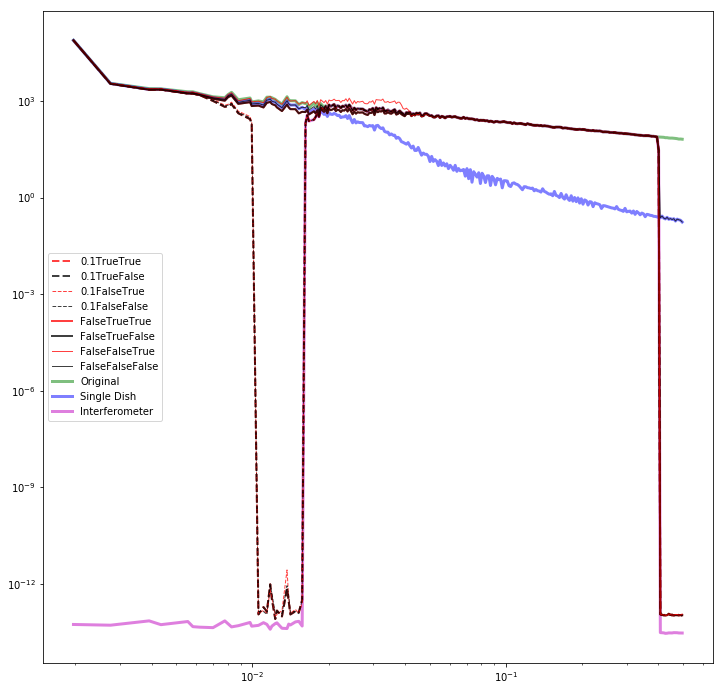

In [31]:
# Feathered dataset
_=pl.figure(1, figsize=(12,12)).clf()
ii = 1
for replace_hires,ls in ((1e-1, '--'),(False,'-')):
    for highpassfilterSD,lw in ((True,2),(False,1)):
        for deconvSD,color in ((True,'r'), (False, 'k')):
            psd2 = np.abs(np.fft.fft2(feathers[replace_hires, highpassfilterSD, deconvSD]))
            pfreq, ppow = psds.pspec(np.fft.fftshift(psd2))
            name = (f"{replace_hires}{highpassfilterSD}{deconvSD}")
            pfreq = pfreq[np.isfinite(ppow)]
            ppow = ppow[np.isfinite(ppow)]
            pl.loglog(pfreq, ppow, label=name, linestyle=ls, linewidth=lw, color=color, alpha=0.75)
            
            ii+=1
psd2 = np.abs(np.fft.fft2(im))
pfreq, ppow = psds.pspec(np.fft.fftshift(psd2))
pfreq = pfreq[np.isfinite(ppow)]
ppow = ppow[np.isfinite(ppow)]
pl.loglog(pfreq, ppow, label='Original', linestyle='-', linewidth=3, color='g', alpha=0.5, zorder=-10)

psd2 = np.abs(np.fft.fft2(singledish_im))
pfreq, ppow = psds.pspec(np.fft.fftshift(psd2))
pfreq = pfreq[np.isfinite(ppow)]
ppow = ppow[np.isfinite(ppow)]
pl.loglog(pfreq, ppow, label='Single Dish', linestyle='-', linewidth=3, color='b', alpha=0.5, zorder=-10)

psd2 = np.abs(np.fft.fft2(im_interferometered))
pfreq, ppow = psds.pspec(np.fft.fftshift(psd2))
pfreq = pfreq[np.isfinite(ppow)]
ppow = ppow[np.isfinite(ppow)]
pl.loglog(pfreq, ppow, label='Interferometer', linestyle='-', linewidth=3, color='m', alpha=0.5, zorder=-10)


_=pl.legend(loc='best')